In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from datetime import datetime

import scipy.sparse as sparse

%matplotlib inline

from implicit.als import AlternatingLeastSquares

import warnings; warnings.simplefilter('ignore')

In [20]:
bookmarks_df = pd.read_csv('hetrec2011-delicious-2k/bookmarks.dat', sep='\\t')
tags_df = pd.read_csv('hetrec2011-delicious-2k/tags.dat', sep='\\t')
user_contacts_df = pd.read_csv('hetrec2011-delicious-2k/user_contacts.dat', sep='\\t')
user_taggedbookmarks_df = pd.read_csv('hetrec2011-delicious-2k/user_taggedbookmarks.dat', sep='\\t')

In [21]:
bookmarks_df.drop_duplicates()
tags_df.drop_duplicates()
user_contacts_df.drop_duplicates()
user_taggedbookmarks_df.drop_duplicates()

print()

In [22]:
user_taggedbookmarks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437593 entries, 0 to 437592
Data columns (total 9 columns):
userID        437593 non-null int64
bookmarkID    437593 non-null int64
tagID         437593 non-null int64
day           437593 non-null int64
month         437593 non-null int64
year          437593 non-null int64
hour          437593 non-null int64
minute        437593 non-null int64
second        437593 non-null int64
dtypes: int64(9)
memory usage: 30.0 MB


In [23]:
bookmarks_df.head()

,id,md5,title,url,md5Principal,urlPrincipal
0,1,ab4954b633ddaf5b5bba6e9b71aa6b70,IFLA - The official website of the Internation...,http://www.ifla.org/,7f431306c428457bc4e12b15634484f,www.ifla.org
1,2,2221e9cd106d269dd34682666f576fa3,gcdp-e.pdf (application/pdf Object),http://archive.ifla.org/VII/s14/nd1/gcdp-e.pdf,1ef8cfcfe968101fa9b4e301847503d4,archive.ifla.org
2,7,c97c571dadaddbbb493126a0d4d01ba3,EdSelect,http://www.edselect.com/,792fd7eb20143386d0c4eb193c6124d,www.edselect.com
3,8,25bfe8dca0ef263ec9c341b9f16c38b5,Cool Canada (Collections Canada),http://www.collectionscanada.gc.ca/cool/index-...,6fce4f6391516f0732531d9cfacda5b7,www.collectionscanada.gc.ca
4,9,c97284629e17b8e2861afaacd59918bc,Kidsreads.com,http://www.kidsreads.com/,5854ce8404857a45373eea01a3d98000,www.kidsreads.com


In [24]:
bookmarks_df['urlPrincipal'].value_counts()

www.youtube.com               1048
www.nytimes.com                639
en.wikipedia.org               585
www.guardian.co.uk             484
mashable.com                   449
code.google.com                417
www.slideshare.net             337
github.com                     325
d.hatena.ne.jp                 293
www.bbc.co.uk                  271
vimeo.com                      262
lifehacker.com                 261
www.readwriteweb.com           241
www.wired.com                  237
www.smashingmagazine.com       228
www.flickr.com                 224
www.google.com                 209
techcrunch.com                 155
news.bbc.co.uk                 129
sites.google.com               123
wordpress.org                  112
www.pbs.org                    111
online.wsj.com                 110
www.ted.com                    110
sixrevisions.com               102
www.makeuseof.com              100
www.telegraph.co.uk             99
chronicle.com                   97
www.huffingtonpost.c

In [25]:
bookmarks_df = bookmarks_df.drop(columns = ['md5','title','url','md5Principal'])

In [26]:
bookmarks_df.columns = ['bookmarkID','url']

In [27]:
tags_df.columns = ['tagID','title_tags']
tags_df.head()

,tagID,title_tags
0,1,collection_development
1,2,library
2,3,collection
3,4,development
4,5,lesson_plan


In [28]:
user_contacts_df.head()

,userID,contactID,date_day,date_month,date_year,date_hour,date_minute,date_second
0,8,28371,4,10,2010,2,14,19
1,8,40306,3,10,2010,12,33,9
2,8,85279,2,10,2010,3,10,48
3,8,91764,4,10,2010,22,43,47
4,8,97723,12,10,2010,3,28,33


In [29]:
user_contacts_df.columns = ['userID','contactID','day','month','year','hour','minute','second']

In [30]:
user_contacts_df.head()

,userID,contactID,day,month,year,hour,minute,second
0,8,28371,4,10,2010,2,14,19
1,8,40306,3,10,2010,12,33,9
2,8,85279,2,10,2010,3,10,48
3,8,91764,4,10,2010,22,43,47
4,8,97723,12,10,2010,3,28,33


In [215]:
user_taggedbookmarks_df['views'] = 1

In [216]:
group_table = user_taggedbookmarks_df.groupby(['userID','bookmarkID'])[['views']].sum().reset_index()
group_table = group_table.merge(bookmarks_df, how = 'left', on = 'bookmarkID')
group_table.head()

,userID,bookmarkID,views,url
0,8,1,1,www.ifla.org
1,8,2,1,archive.ifla.org
2,8,7,3,www.edselect.com
3,8,8,3,www.collectionscanada.gc.ca
4,8,9,2,www.kidsreads.com


In [217]:
group_table = group_table.dropna()
group_table['users_m'] = group_table['userID'].astype("category").cat.codes
group_table['bookmarks_m'] = group_table['bookmarkID'].astype("category").cat.codes

In [218]:
group_table.head()

,userID,bookmarkID,views,url,users_m,bookmarks_m
0,8,1,1,www.ifla.org,0,0
1,8,2,1,archive.ifla.org,0,1
2,8,7,3,www.edselect.com,0,2
3,8,8,3,www.collectionscanada.gc.ca,0,3
4,8,9,2,www.kidsreads.com,0,4


In [219]:
group_table = group_table.loc[group_table.views != 0]

In [220]:
item_lookup = group_table[['bookmarkID', 'bookmarks_m', 'url']].drop_duplicates()
item_lookup['bookmarks_m'] = item_lookup.bookmarks_m.astype(str)

In [222]:
url_id_name = {}

for index, row in tqdm_notebook(item_lookup.iterrows()):
    url_id_name[row.bookmarks_m] = row.url

In [224]:
group_table = group_table.drop(['userID', 'bookmarkID', 'url'], axis=1)

In [225]:
group_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104799 entries, 0 to 104798
Data columns (total 3 columns):
views          104799 non-null int64
users_m        104799 non-null int16
bookmarks_m    104799 non-null int32
dtypes: int16(1), int32(1), int64(1)
memory usage: 2.2 MB


In [226]:
group_table.describe()

,views,users_m,bookmarks_m
count,104799.000000,104799.000000,104799.000000
mean,4.175546,895.579939,27118.282102
std,3.200233,548.079983,20260.652700
min,1.000000,0.000000,0.000000
25%,2.000000,397.000000,9689.500000
50%,3.000000,893.000000,20944.000000
75%,5.000000,1375.000000,43906.500000
max,70.000000,1866.000000,69222.000000


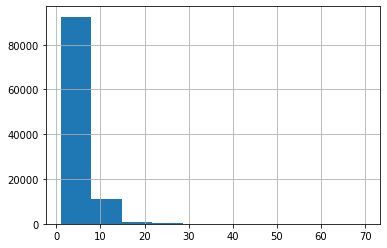

In [227]:
group_table.views.hist()

In [228]:
df = group_table
df.head()

,views,users_m,bookmarks_m
0,1,0,0
1,1,0,1
2,3,0,2
3,3,0,3
4,2,0,4


In [231]:
users = list(np.sort(df.users_m.unique()))
bookmark = list(np.sort(df.bookmarks_m.unique()))
views = list(df.views)

In [232]:
users[:5]

[0, 1, 2, 3, 4]

In [233]:
bookmark[:5]

[0, 1, 2, 3, 4]

In [234]:
views[:5]

[1, 1, 3, 3, 2]

In [235]:
len(users)

1867

In [236]:
len(bookmark)

69223

In [249]:
rows = df.users_m.astype(int)
cols = df.bookmarks_m.astype(int)

In [250]:
rows[1]

0

In [251]:
cols[1]

1

In [253]:
data_sparse = sparse.csr_matrix((views, (cols, rows)), shape=(len(bookmark), len(users)))

In [254]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

100%|██████████| 15.0/15 [00:00<00:00, 17.78it/s]


In [255]:
userid = 0

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

In [256]:
recommendations

[(3270, 0.24214283),
 (1582, 0.2205754),
 (1137, 0.21920289),
 (19854, 0.21628055),
 (19839, 0.20969653),
 (19860, 0.20032915),
 (19862, 0.19683906),
 (19866, 0.19615814),
 (9887, 0.19272017),
 (19861, 0.19128653)]

In [257]:
for r in recommendations:
    print(url_id_name[str(r[0])])

www.voki.com
www.wordle.net
animoto.com
www.youtube.com
www.sldirectory.com
www.search-cube.com
www.visuwords.com
udleditions.cast.org
www.teachertube.com
blachan.com


In [259]:
itemid = 107
related = model.similar_items(itemid)

In [260]:
related

[(107, 0.11167308),
 (93, 0.11095884),
 (113, 0.11095213),
 (110, 0.11093406),
 (106, 0.11093404),
 (111, 0.11091643),
 (95, 0.11091642),
 (109, 0.11090896),
 (104, 0.110908955),
 (97, 0.11087035)]

In [262]:
url_id_name['107']

'www.artofalexfischer.com'

In [264]:
for a in related:
    print(url_id_name[str(a[0])])

www.artofalexfischer.com
www.oshiete-kun.net
finn-johannsen.de
www.youtube.com
www.lorenzobernet.com
www.youtube.com
ubu.com
www.lelesaveri.com
sethlower.com
www.youtube.com
